In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [3]:
from ml_core.preprocessing.dataset import Dataset
from torch.utils.data import DataLoader, ConcatDataset
import albumentations as A
from pathlib import Path

In [4]:
aug_transform = A.Compose([
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Rotate(),
    A.OneOf([
        A.HueSaturationValue(),
        A.ToGray()
    ])
])

In [5]:
class_name = "Glomerulus" # can be changed to Artery as well
dataset = "KI"
data_root = Path(f"../../data/{dataset}_dataset/hdf5_data/")
train_fname = data_root / f"Mixed_{class_name}_train.h5"
val_fname = data_root / f"Mixed_{class_name}_val.h5"

In [6]:
train_dataset = Dataset(train_fname, aug_transform=aug_transform, use_edge_mask=True)
val_dataset = Dataset(val_fname, use_edge_mask=True)

In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)

In [8]:
from pytorch_lightning import Trainer
from ml_core.training.unet import UNet

In [9]:
trainer = Trainer(gpus=1, 
                  default_root_dir=Path(f"../../output/{dataset}/{class_name}"),
                  max_epochs=30,
                  checkpoint_callback=False,
                  log_every_n_steps=1,
                  flush_logs_every_n_steps=50)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [10]:
unet = UNet(in_channels=3,
            n_classes=2,
            depth = 5,# this depth may need to be modified
            wf = 3,
            padding = True,
            batch_norm = True,
            up_mode = "upconv")

In [11]:
trainer.fit(unet, train_dataloader, val_dataloader)


  | Name      | Type             | Params
-----------------------------------------------
0 | down_path | ModuleList       | 296 K 
1 | up_path   | ModuleList       | 191 K 
2 | last      | Conv2d           | 18    
3 | criterion | CrossEntropyLoss | 0     
/home/henryhuang/.conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)
/home/henryhuang/.conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/home/henryhuang/.conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


1

In [12]:
data_root = Path("../../data/AAPI_dataset/hdf5_data/")
train_fname = data_root / f"HE_{class_name}_train.h5"
val_fname = data_root / f"HE_{class_name}_val.h5"

In [13]:
aapi_train_dataset = Dataset(train_fname, use_edge_mask=True)
aapi_val_dataset = Dataset(val_fname, use_edge_mask=True)
concat_dataset = ConcatDataset([aapi_train_dataset, aapi_val_dataset])
aapi_whole_val_dataloader = DataLoader(concat_dataset, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

In [14]:
trainer.test(model=unet, test_dataloaders=val_dataloader)

/home/henryhuang/.conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Your test_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)
/home/henryhuang/.conda/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/f1_score': tensor(0.9349, device='cuda:0'),
 'test/loss': tensor(0.0748, device='cuda:0'),
 'train/f1_score': tensor(0.9363, device='cuda:0'),
 'train/loss': tensor(0.0785, device='cuda:0'),
 'val/f1_score': tensor(0.9340, device='cuda:0'),
 'val/loss': tensor(0.0748, device='cuda:0')}
--------------------------------------------------------------------------------



[{'train/loss': 0.07848207652568817,
  'train/f1_score': 0.9362977147102356,
  'val/loss': 0.07479044049978256,
  'val/f1_score': 0.934045672416687,
  'test/loss': 0.07479044049978256,
  'test/f1_score': 0.9349313974380493}]

In [17]:
from ml_core.preprocessing.dataset import visualize_one_sample

Sample 29 has the 29-th positive mask.


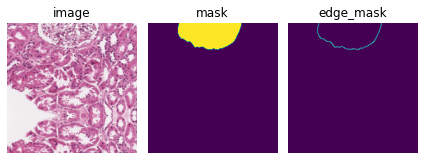

In [18]:
visualize_one_sample(aapi_train_dataset, 29, positive_only=True)

In [19]:
trainer.save_checkpoint(f"../../output/KI/Glomerulus/best_model.h5")